<a href="https://colab.research.google.com/github/Nickimani/Airbnb_Project/blob/master/Airbnb_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Project

# 1. Business Understanding 

# 2. Data Understanding

# 3. Loading Data

## 3.1 Importing Libraries

In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive', timeout_ms=900000) # timeout = 15 min

Mounted at /content/drive


In [ ]:
# installing necessary libraries
# Reverse geoencoder
!pip install reverse_geocoder 
# pandas profiling
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 5.2 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=c3f19d215619297473d077faf4fc811f5da3f489e594d352bb7062024f4a65a5
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing libraries

import string
import re
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import reverse_geocoder as rg

## 3.2 Loading The DataFrames

In [ ]:
# loading the DataFrames
listings_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/listings.csv')
reviews_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/reviews.csv')
metadata_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/data_dictionary.csv')

In [ ]:
# a function returning the datastructure of a the input dataframe
def data_structure(dataframe, data_name):
    """ 
    Returns datashape and data info. 
    """
    print(f'{data_name} dataframe shape:', dataframe.shape)
    print('-'*120)
    print(dataframe.info())

# a function returning a dataframe of the completeness of the features in the input dataframe
def percentage_completeness(dataframe):
    """
    Returns a dataframe showcasing the percentage completeness of the columns in a dataframe    
    """
    # length of dataframe
    tot_entries = len(dataframe) 
    # name of columns list
    columns = list(dataframe.columns) 
    perc_completeness = [] 

    for column in columns:
        # taking number of missing records
        missing = dataframe[column].isna().sum() 
        # calculating percentage of completeness in column
        perc_null_counts = (1 - (missing / tot_entries)) * 100 
        perc_completeness.append(round(perc_null_counts, 2)) 
    # creating dataframe of column and completeness
    output = pd.DataFrame(list(zip(columns, perc_completeness)), 
                          columns=['Feature', '%_completeness']) 
    # sorting the values
    output = output.sort_values(by='%_completeness', ascending=True) 
    output.reset_index(inplace=True, drop=True)

    return output

# a function that pulls valuecounts from a column
def value_count(dataframe, column):
    """
    Returns the value counts for unique value in the column specified
    """
    # getting the value counts
    val_count = dataframe[column].value_counts() 
    # converting list output to dataframe
    result = val_count.to_frame(name='Count(s)') 

    return result

# a funtion for removing the % sign from the strings    
def strip_signs(dataframe, column):
    """
    Takes in a dataframe and the column to be cleaned. 
    The column should have a prefix of suffix that if removed,would make the column convertible to a numeric datatype
    Returns a replacement of the input column cleaned and converted to float dtype.
    """
    # making sure its a series
    feature = pd.Series(dataframe[column]) 
    # striping % sign from string
    feature = feature.str.strip(to_strip='%') 
    # converting datatype
    final_feature = feature.astype('float') 

    return final_feature


# a function for plotting a boxplot for a series
def box_plot(series):
    """
    Returns a boxplot of the column specified    
    """
    fig, ax = plt.subplots(figsize=(20,10))
    # creating the boxplot
    ax = sns.boxplot(x=series, linewidth=1, palette='Set2') 
    # Give the plot a main title
    ax.set_title(f'{series.name}, Airbnb Cape town', fontsize=30,pad=30) 
    # Set text for the x axis,
    ax.set_xlabel(series.name, fontsize=20, labelpad=15)
    sns.despine(offset=5, left=True);

# Build a function for regex stripping maybe linked to strip signs

### Data Structure

In [ ]:
# data_structure(listings_df, 'listing_df') # listings df structure

The listings dataFrame has 18903 rows with 74 columns. 41 of the columns are of numeric type and The remaining 33 are of object type.

In [ ]:
# selecting important columns as per the business problem
relevant_cols = ['id', 'listing_url', 'host_url', 'last_scraped', 'host_since', 'neighbourhood_cleansed', 
                 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
                 'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
                 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                 'instant_bookable', 'calculated_host_listings_count'
                 ]
# subsetting a dataframe of the relevant columns
listings_df = listings_df[relevant_cols]

In [ ]:
# new_listings df structure
data_structure(listings_df, 'listing_df') 

listing_df dataframe shape: (18903, 29)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18903 entries, 0 to 18902
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18903 non-null  int64  
 1   listing_url                     18903 non-null  object 
 2   host_url                        18903 non-null  object 
 3   last_scraped                    18903 non-null  object 
 4   host_since                      18902 non-null  object 
 5   host_location                   18812 non-null  object 
 6   neighbourhood_cleansed          18903 non-null  object 
 7   host_response_time              14710 non-null  object 
 8   host_response_rate              14710 non-null  object 
 9   host_acceptance_rate            16542 non-null  object

In [ ]:
# viewing listings df
listings_df.head(3) 

,id,listing_url,host_url,last_scraped,host_since,host_location,neighbourhood_cleansed,host_response_time,host_response_rate,host_acceptance_rate,...,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count
0,30332317,https://www.airbnb.com/rooms/30332317,https://www.airbnb.com/users/show/98554302,2022-06-22,2016-10-07,"Cape Town, Western Cape, South Africa",Ward 15,within an hour,100%,100%,...,"$1,350.00",2,5.00,5.0,5.0,5.0,5.0,5.00,t,7
1,9126484,https://www.airbnb.com/rooms/9126484,https://www.airbnb.com/users/show/3410651,2022-06-22,2012-08-29,"Cape Town, Western Cape, South Africa",Ward 61,within a few hours,100%,50%,...,"$1,750.00",15,4.87,5.0,5.0,5.0,5.0,4.93,f,1
2,44482125,https://www.airbnb.com/rooms/44482125,https://www.airbnb.com/users/show/98554302,2022-06-22,2016-10-07,"Cape Town, Western Cape, South Africa",Ward 15,within an hour,100%,100%,...,"$1,350.00",0,NaN,NaN,NaN,NaN,NaN,NaN,t,7


In [ ]:
# reviews_df structure
data_structure(reviews_df, 'reviews_df') 

reviews_df dataframe shape: (363065, 6)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363065 entries, 0 to 363064
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     363065 non-null  int64 
 1   id             363065 non-null  int64 
 2   date           363065 non-null  object
 3   reviewer_id    363065 non-null  int64 
 4   reviewer_name  363065 non-null  object
 5   comments       363018 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.6+ MB
None


Reviews dataframe has only 1 column with nan values.
The nature of the comments column makes it difficult to fill the nan values.

In [ ]:
# dropping nan values in reviews_df
reviews_df.dropna(inplace=True)

# viewing reviews df
reviews_df.head(3) 

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,30332317,597314314,2020-01-25,7812767,Alan,Lovely rustic accommodation in a picturesque r...
1,30332317,532436007654450454,2022-01-04,367340518,Courtney,The hosts are friendly and takes good care of ...
2,9126484,63063726,2016-02-20,50272994,Carla,6 St Georges Building was lovely in every way....


# 4. Exploratory Data Analysis

## 4.1 Completeness

In [ ]:
# checking percentage null value counts in listings 
listings_completeness = percentage_completeness(listings_df) 
# filtering out columns with complete records
listings_completeness = listings_completeness[listings_completeness['%_completeness'] < 100] 
listings_completeness

,Feature,%_completeness
0,review_scores_location,71.97
1,review_scores_checkin,71.97
2,review_scores_communication,71.98
3,review_scores_accuracy,71.98
4,review_scores_cleanliness,71.99
5,review_scores_rating,72.79
6,host_response_rate,77.82
7,host_response_time,77.82
8,host_acceptance_rate,87.51
9,bedrooms,93.71


In [ ]:
# checking number of columns with missing values
print('The number of columns with missing values are:', len(listings_completeness))

The number of columns with missing values are: 15


### 'review_score' features

Dealing with columns that have 'review_score' in their labels. 

There is ~30% missing values in 'review_score_' columns.

In [ ]:
# Creating a list of the review_score columns
review_list = [column for column in listings_df.columns if 'review_score' in column.strip()]
# subsetting a dataframe of review list
review_cols_df = listings_df[review_list].copy() 
# checking the datatype for these columns
listings_df[review_list].dtypes

review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
dtype: object

All review_score_ columns are of numeric type.

In [ ]:
# checking the column descriptions
review_cols_df.describe().T 

,count,mean,std,min,25%,50%,75%,max
review_scores_rating,13760.0,4.666231,0.684017,0.0,4.64,4.86,5.0,5.0
review_scores_accuracy,13607.0,4.757262,0.490736,0.0,4.73,4.91,5.0,5.0
review_scores_cleanliness,13608.0,4.730264,0.492878,0.0,4.67,4.89,5.0,5.0
review_scores_checkin,13604.0,4.808905,0.462444,0.0,4.81,4.97,5.0,5.0
review_scores_communication,13607.0,4.802807,0.479074,0.0,4.81,4.97,5.0,5.0
review_scores_location,13604.0,4.803673,0.414366,0.0,4.78,4.93,5.0,5.0


The missing values will be filled with the median of the respective column.

In [ ]:
# imputing missing values with median
listings_df[review_list] = listings_df[review_list].fillna(listings_df[review_list].median())

In [ ]:
# rounding off ratings values 
listings_df[review_list] = listings_df[review_list].round(0)

In [ ]:
# checking value counts
for feature in review_list:
    print(value_count(listings_df, feature))
    # limiting long output

     Count(s)
5.0     15098
4.0      1941
1.0       219
3.0       171
2.0        45
     Count(s)
5.0     15750
4.0      1441
3.0       148
1.0        94
2.0        41
     Count(s)
5.0     15400
4.0      1758
3.0       187
1.0        77
2.0        52
     Count(s)
5.0     16134
4.0      1107
3.0       115
1.0        91
2.0        27
     Count(s)
5.0     16073
4.0      1153
3.0       115
1.0        91
2.0        42
     Count(s)
5.0     16137
4.0      1165
3.0        83
1.0        61
2.0        28


The number of rating scores that equal to 0 after rouding off are negligible compared to the size of the dataset and other class couts. A zero rating doesn't make much sense, changing them to 1 is more sensible.

In [ ]:
for feature in review_list:
    # replacing 0 values with 1
    listings_df[feature] = listings_df[feature].replace(to_replace=0, value=1) 

### bedrooms & beds features
~6% of data is missing from bedrooms and ~2% is missing from beds columns.

In [ ]:
# bedrooms unique values
print(listings_df['bedrooms'].unique()[:23])
print()
# beds unique values
print(listings_df['beds'].unique()[:10])

[ 1.  2.  5.  3. nan  6.  4. 10.  7.  8.  9. 12. 16. 19. 41. 40. 11. 14.
 13. 18. 17. 15. 20.]

[ 1.  3.  2.  4.  5.  6.  8. nan  7. 49.]


There seems to be outliers in these columns. 

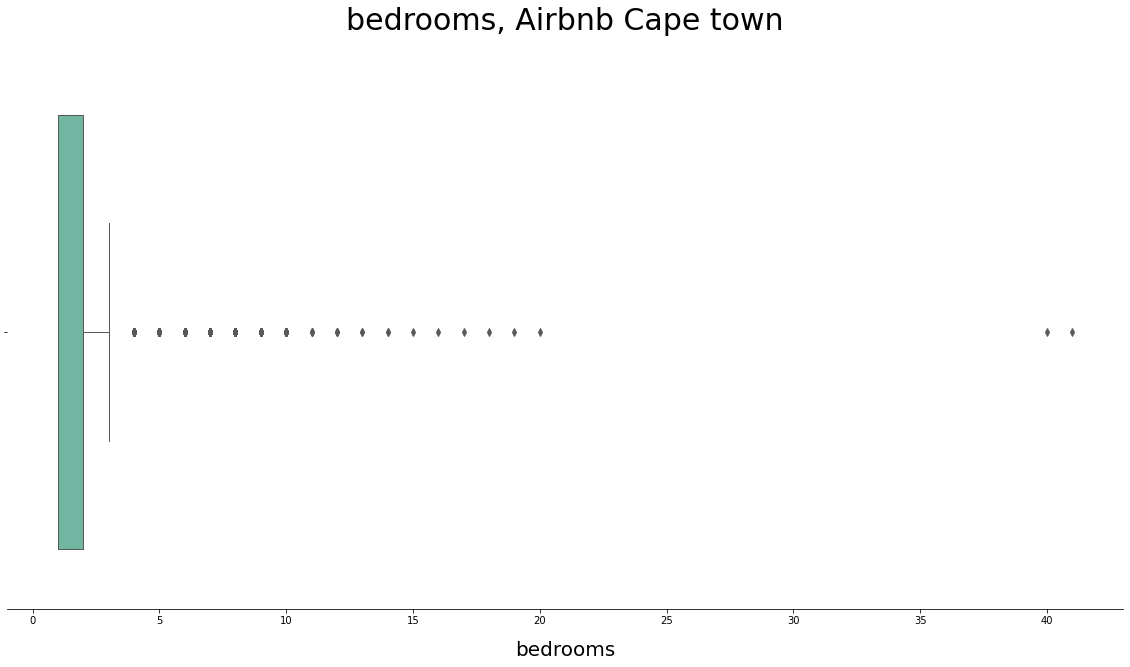

In [ ]:
# checking if there are outliers in the bedrooms column
box_plot(listings_df['bedrooms'])

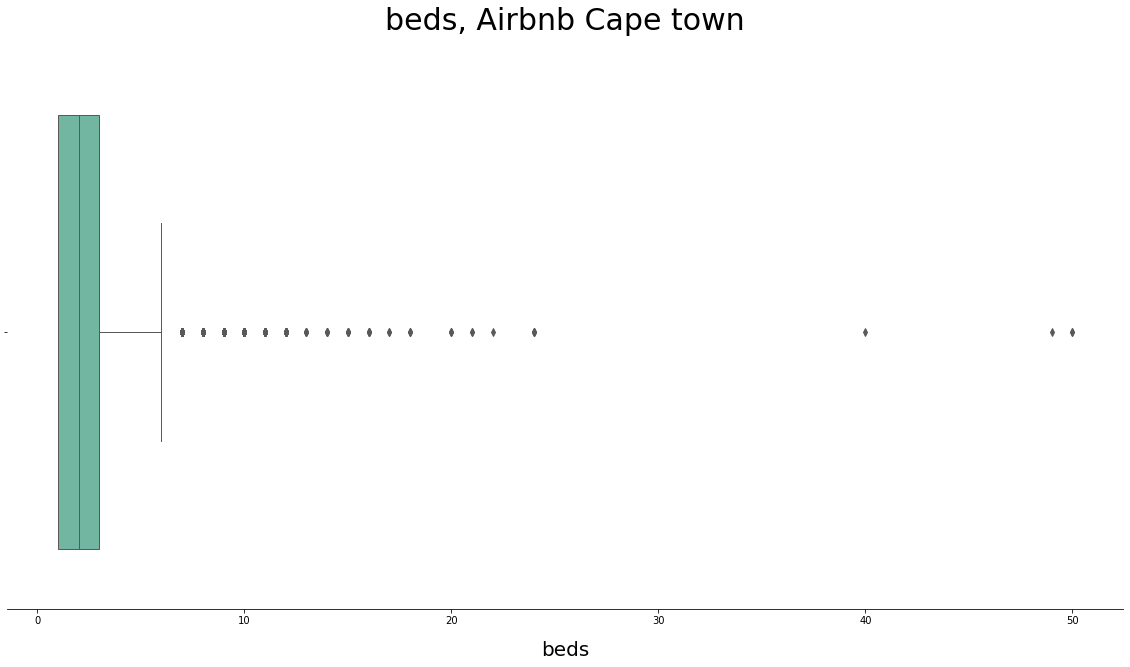

In [ ]:
# checking if there are outliers in the bed column
box_plot(listings_df['beds']) 

In [ ]:
# subsetting extreme outliers in bedrooms and beds columns
listings_df[(listings_df['bedrooms'] >= 24) | (listings_df['beds'] >= 24)][['bedrooms', 'beds', 'price', 'bathrooms_text']]

,bedrooms,beds,price,bathrooms_text
148,10.0,49.0,$840.00,32 baths
1742,12.0,24.0,"$3,361.00",2 baths
7064,12.0,24.0,"$9,800.00",6 baths
8401,41.0,50.0,"$1,689.00",1 bath
8966,40.0,50.0,$807.00,42 baths
12250,1.0,24.0,$350.00,1 shared bath
12517,14.0,24.0,$400.00,2 shared baths
12518,13.0,40.0,$686.00,9 baths


In [ ]:
# shape before dropping outliers
print('Shape Before:', np.shape(listings_df))
# dropping outliers
listings_df = listings_df[listings_df['beds'] < 24].copy()
listings_df = listings_df[listings_df['bedrooms'] < 24].copy()
# shape after
print('Shape After:', np.shape(listings_df))
# values dropped
print('Records dropped:', 1428)

Shape Before: (18903, 29)
Shape After: (17475, 29)
Records dropped: 1428


median for bedrooms is 1 and for beds is 2.

In [ ]:
# fill missing values with the median
listings_df['bedrooms'].fillna(value=listings_df['bedrooms'].median(), inplace=True)
# fill missing values
listings_df['beds'].fillna(value=listings_df['beds'].median(), inplace=True)

### bathrooms_text feature
~2% of data is missing in bathrooms_text column.

In [ ]:
# checking bathrooms unique values
listings_df['bathrooms_text'].unique()[:10] 

array(['1 bath', '2 baths', '1.5 baths', '5 baths', '3 baths',
       '3.5 baths', '1 private bath', '6.5 baths', '2.5 baths',
       '4.5 baths'], dtype=object)

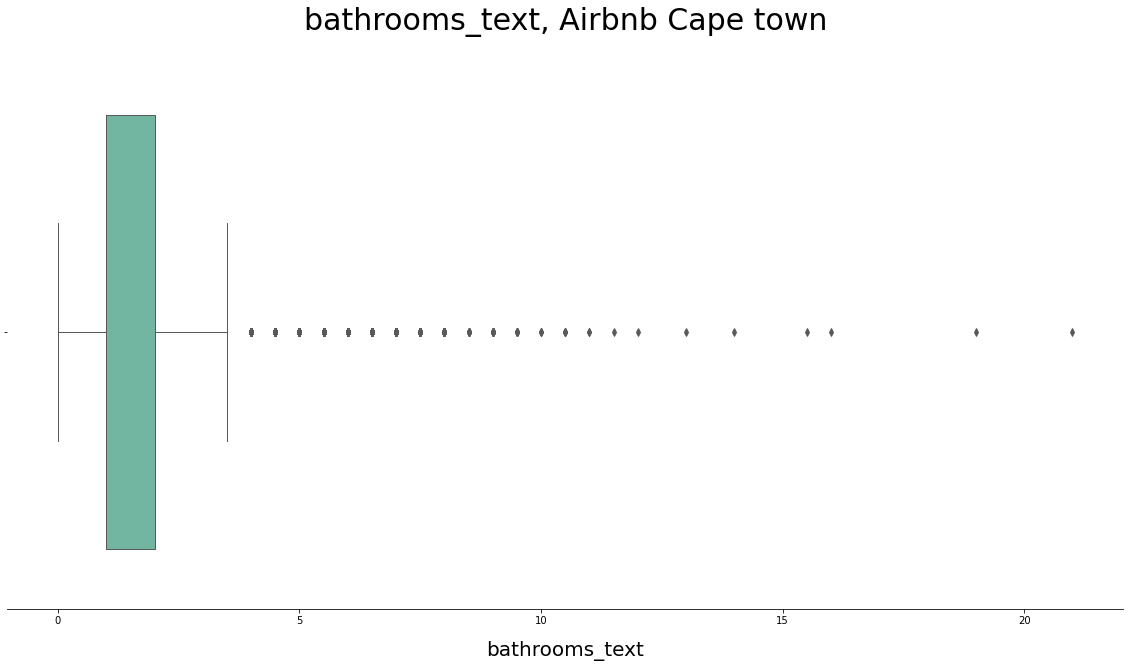

In [ ]:
# strip the records to remain with the numerical value strings
listings_df['bathrooms_text'] = listings_df['bathrooms_text'].str.extract('(\d+\.?\d*)')
# changing column to float
listings_df['bathrooms_text'] = listings_df['bathrooms_text'].astype('float')
# checking if there are outliers in bathrooms_text
box_plot(listings_df['bathrooms_text']) 

bathrooms median is 1.

In [ ]:
# fill missing values with median
listings_df['bathrooms_text'].fillna(value=listings_df['bathrooms_text'].median(), inplace=True) 
# changing column name 
listings_df.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

### some 'host' features

Dealing with host_response_time, host_response_rate & host_acceptance_rate columns.

host_response_time and host_response_rate have ~23% of missing data, and host_acceptance_rate has ~13% of missing data.

In [ ]:
# making a list of the columns being tackled
host_reactions = ['host_response_time', 'host_response_rate', 'host_acceptance_rate']
# checking unique counts
print('host_response_time unique counts are:', listings_df[host_reactions[0]].nunique())
print()
print(listings_df['host_response_time'].unique())
print()
print('host_response_rate unique counts are:', listings_df[host_reactions[1]].nunique())
print()
print(listings_df[host_reactions[1]].unique()[:10])
print()
print('host_acceptance_rate unique counts are:', listings_df[host_reactions[2]].nunique())
print()
print(listings_df[host_reactions[2]].unique()[:10])

host_response_time unique counts are: 4

['within an hour' 'within a few hours' nan 'within a day'
 'a few days or more']

host_response_rate unique counts are: 42

['100%' nan '50%' '80%' '87%' '67%' '75%' '33%' '90%' '70%']

host_acceptance_rate unique counts are: 87

['100%' '50%' '67%' '71%' nan '94%' '93%' '11%' '83%' '99%']


host_response_time is a categorical column, its missing values will be imputed with 'unknown' as a category. The other 2 columns should be numerical but have been recorded as strings. Some manipulations need to be done to them.

In [ ]:
# filling nan values with unknown
listings_df['host_response_time'] = listings_df['host_response_time'].fillna('unknown') 
# stripping % signs from the columns
listings_df['host_response_rate'] = strip_signs(listings_df, 'host_response_rate')
listings_df['host_acceptance_rate'] = strip_signs(listings_df, 'host_acceptance_rate') 

host_response_rate median is 100% while host_acceptance median is 95%. Is that the general trend?

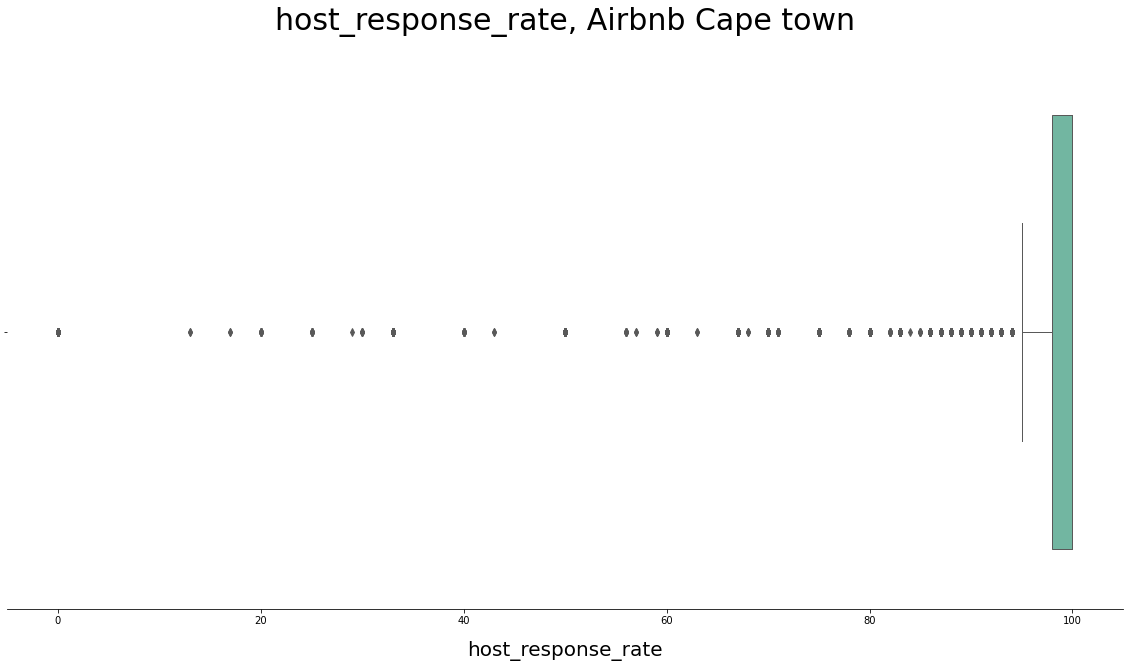

In [ ]:
# boxplot of host_response_rate
box_plot(listings_df['host_response_rate'])

In [ ]:
# filling missing values with median
listings_df['host_response_rate'].fillna(value=listings_df['host_response_rate'].median(), inplace=True) 

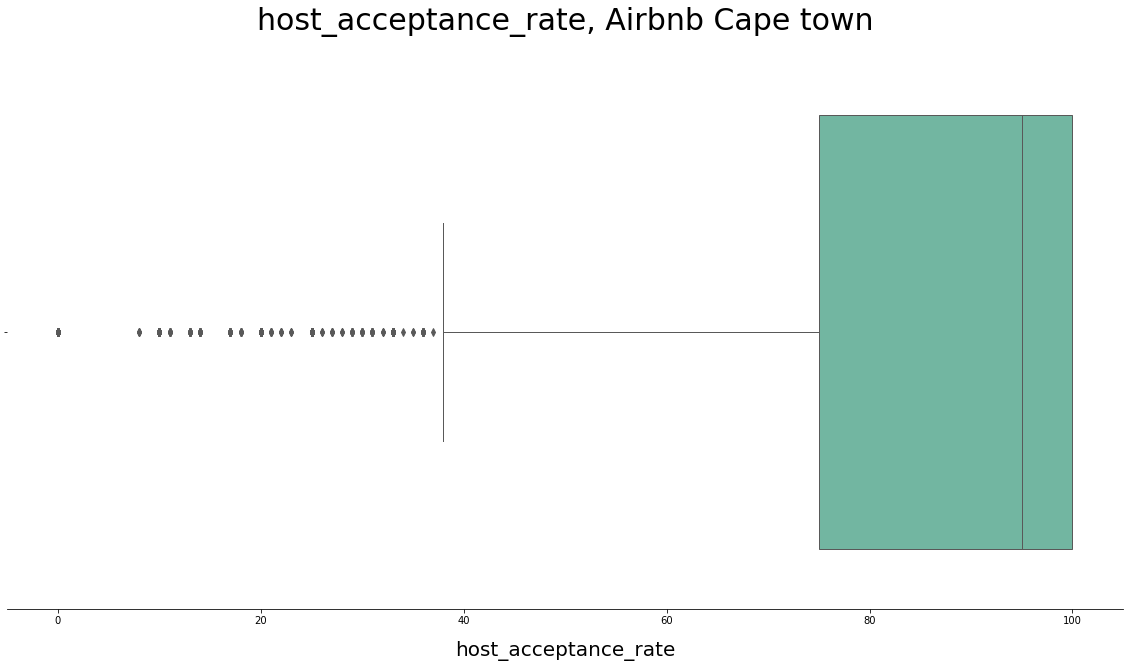

In [ ]:
# boxplot of host_acceptance rate
box_plot(listings_df['host_acceptance_rate']) 

In [ ]:
# filling missing values with median
listings_df['host_acceptance_rate'].fillna(value=listings_df['host_acceptance_rate'].median(), inplace=True)

acceptance rate and response rate need to be transformed to categorical variables. To do that rounding off of the values required.

In [ ]:
# rounding off the values
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].apply(lambda x: round(x, -1))
listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(lambda x: round(x, -1))

### Other host features

Dealing with host_name, host_since, host_identity_verified, host_is_superhost, host_has_profile_pic, host_picture_url, host_listings_count & host_total_listings_count columns.

In [ ]:
# list of 'host' columns that have been dealt with already
already_dealt = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_location']
# making a list of columns containing 'host' in their names but that haven't been dealt with
rem_host_cols = [column for column in listings_df.columns if 'host' in column.strip() and column not in already_dealt]
# filtering out 'host columns' that are complete
host_traits = [column for column in rem_host_cols if column in list(listings_completeness['Feature'])]
host_traits

['host_since', 'host_is_superhost']

both of them have ~0.01% of missing values

In [ ]:
# sum of nan values in host_since
print(listings_df['host_since'].isna().sum())
# Dropping null row 
listings_df.dropna(subset= ["host_since"], inplace= True) 

1


In [ ]:
# viewing the host columns
listings_df[host_traits].head(3) 

,host_since,host_is_superhost
0,2016-10-07,f
1,2012-08-29,f
2,2016-10-07,f


The host_since column contains dates of when a host started being a host. The values in this column will be sliced, and only the year will be left. The column will also be transformed into a integer data type.

In [ ]:
# slicing the year off the records
listings_df['host_since'] = listings_df['host_since'].apply(lambda x: x[:4]) 
# changing column to int
listings_df['host_since'] = listings_df['host_since'].astype(int) 

host is superhost needs to be transformed into a better representation for a binary category.

In [ ]:
# repacing values to make column a bool dtype
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].replace({'t': 1, 'f': 0})

## 4.2 uniqueness

In [ ]:
# checking for duplicates
listings_df.drop(columns='amenities').duplicated().sum()

0

#### Current dataframe info after cleaning is:

In [ ]:
# current completeness
percentage_completeness(listings_df)[:4] 

,Feature,%_completeness
0,host_location,99.51
1,id,100.00
2,review_scores_location,100.00
3,review_scores_communication,100.00


## 4.3 Cleaning remaining features

### instant_bookable feature

In [ ]:
# checking value_counts
listings_df['instant_bookable'].value_counts()

f    9805
t    7669
Name: instant_bookable, dtype: int64

In [ ]:
# repacing values to make column a bool dtype
listings_df['instant_bookable'] = listings_df['instant_bookable'].replace({'t': 1, 'f': 0})

### coordinate features

Dealing with latitude & longitude 

In [ ]:
# To DO!!!

**Testing location filler.**

In [ ]:
# listings_df[['longitude', 'latitude']].head()

In [ ]:
# v= rg.search((-34.03149, 18.82689))

In [ ]:
# test["municipal"] = rg.search((test.latitude, test.longitude))
# test.head()

In [ ]:
# location_df = listings_df[['latitude', 'longitude']]

# # def locate(test, "latitude", "longitude"):
# #   location = rg.search((test["latitude"][0], test["longitude"][0]))
# #   return location[0]["admin2"]

# location_df.head()

### room_type & accomodates features

In [ ]:
# viewing the columns
listings_df[['room_type', 'accommodates']].head(3) 

,room_type,accommodates
0,Entire home/apt,2
1,Entire home/apt,4
2,Entire home/apt,2


In [ ]:
# checking unique values in room type column
print('The unique values in room_type column = ', listings_df['room_type'].nunique())
print('-'*100)
print(listings_df['room_type'].unique()[:5])
print()
# checking unique values in room type column
print('The unique values in accommodates column = ', listings_df['accommodates'].nunique())
print('-'*100)
print(listings_df['accommodates'].unique()[:5])
print()
# maximum accommodates 
print('The max number a listing can accommodate = ', listings_df['accommodates'].max()) 
print()
# minimum accommodates
print('The min number a listing can accommodate ', listings_df['accommodates'].min()) 

The unique values in room_type column =  4
----------------------------------------------------------------------------------------------------
['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']

The unique values in accommodates column =  16
----------------------------------------------------------------------------------------------------
[ 2  4 10  6  5]

The max number a listing can accommodate =  16

The min number a listing can accommodate  1


### amenities feature & amenities_count feature engineering

In [ ]:
# viewing amenities column
listings_df['amenities'].head() 

0    ["Hot water", "Cooking basics", "Iron", "Free ...
1    ["Hot water", "Cooking basics", "Iron", "Dryin...
2    ["TV", "Long term stays allowed", "Cooking bas...
3    ["TV", "Gym", "Long term stays allowed", "Heat...
4    ["TV", "Long term stays allowed", "Heating", "...
Name: amenities, dtype: object

In [ ]:
# Splitting amenities column and get amenities count words
# then creating a new column "amenities_count"

# listings_df['amenities_count'] = listings_df['amenities'].str.split(',').str.len()
# # tramsform amenities records from list to string type
# # listings_df.amenities = listings_df['amenities'].str.replace("[{}]", "").str.replace('"', "").str.replace('[',"").str.replace(']',"")

# creating a list of lower and uppercase letters 
letters = string.ascii_letters
# splitting each record to extract the amenities
amenities_split = listings_df['amenities'].apply(lambda x: x.split('"'))
new_amenities = []
# making a list of lists 
for split in amenities_split:
    res = [x for x in split if x[0] in letters]
    new_amenities.append(res)

# replacing amenities with the list of lists
listings_df['amenities'] = new_amenities
# engineering a new column that is the count of amenities per record
listings_df['amenities_count'] = listings_df['amenities'].apply(lambda x: len(x))
# checking unique counts
listings_df['amenities_count'].nunique()

81

In [ ]:
listings_df['amenities_count'].value_counts().head(40)

10    545
9     464
17    442
5     438
16    436
18    431
15    430
27    423
13    422
14    418
29    415
24    411
31    409
19    409
20    407
25    404
21    397
12    395
30    393
23    389
11    386
22    386
34    378
28    376
26    367
33    366
32    360
35    356
39    343
36    308
37    300
38    292
40    285
41    280
8     275
43    268
42    232
44    229
7     226
45    225
Name: amenities_count, dtype: int64

In [ ]:
listings_df[listings_df['amenities_count'] > 70]['amenities'][403]

['Board games',
 'Hot water',
 'Cleaning products',
 'Cooking basics',
 'Indoor fireplace',
 'Iron',
 'Drying rack for clothing',
 'TV with standard cable',
 'Coffee maker',
 'BBQ grill',
 'Dining table',
 'Washer',
 'Ethernet connection',
 'Pocket wifi',
 'Portable fans',
 'Private hot tub',
 'Free residential garage on premises \\u2013 4 spaces',
 'Private pool',
 'Bed linens',
 'Free street parking',
 'Freezer',
 'Dryer',
 'High chair',
 'Shampoo',
 'Clothing storage: wardrobe',
 'Crib',
 'Bathtub',
 'Outdoor furniture',
 'Private entrance',
 'Keypad',
 'Cleaning before checkout',
 'Wifi',
 'Safe',
 'Outdoor dining area',
 'Heating',
 'Conditioner',
 'Children\\u2019s books and toys for ages 0-2 years old',
 'Baking sheet',
 'Private patio or balcony',
 'Changing table',
 'Stove',
 'Elevator',
 'Extra pillows and blankets',
 'Hot water kettle',
 'Wine glasses',
 'Children\\u2019s dinnerware',
 'First aid kit',
 'Microwave',
 'Refrigerator',
 'Hair dryer',
 'Laundromat nearby',
 'Bar

### last_scraped feature & hosting_age feature engineering

In [ ]:
# viewing 'scrape' columns
listings_df['last_scraped'].head(2) 

0    2022-06-22
1    2022-06-22
Name: last_scraped, dtype: object

In [ ]:
# slicing the year from last scraped
listings_df['last_scraped'] = listings_df['last_scraped'].apply(lambda x: x[:4]) 
# changing column data type
listings_df['last_scraped'] = listings_df['last_scraped'].astype(int) 
# creating a column to show age of the host
listings_df['hosting_age'] = listings_df['last_scraped'] - listings_df['host_since']
# dropping last_scrapped and host_since columns
listings_df.drop(columns= ['last_scraped', 'host_since'], inplace= True) 

#### **We need to decide which features will be categorical.**

In [ ]:
# checking the unique counts of the features in the dataframe
unique_count = []

for column in list(listings_df.columns):
    # because list type is not hashable
    if column != 'amenities': 
        unique_val = listings_df[column].nunique()
        unique_count.append(unique_val)
    else: 
        unique_count.append('list_type')
        
# creating a dataframe for readability
pd.DataFrame(list(zip(list(listings_df.columns), unique_count)), columns=['feature', 'unique_count'])

,feature,unique_count
0,id,17474
1,listing_url,17474
2,host_url,9429
3,host_location,614
4,neighbourhood_cleansed,91
5,host_response_time,5
6,host_response_rate,11
7,host_acceptance_rate,11
8,host_is_superhost,2
9,latitude,12181


With cleaning finished. A reset of the dataframe index is needed.

In [ ]:
# resetting dataframe index
listings_df.reset_index(drop=True, inplace=True)

## 4.4 Bivariate Analysis

In [ ]:
# dataframe of continuous variables in the dataframe
continuous_var_df = listings_df[['price','number_of_reviews']]
# dataframe of categorical variables in the dataframe
categorical_var_df = listings_df[['host_response_time', 'host_response_rate','host_acceptance_rate', 'host_is_superhost', 'room_type',
                              'accommodates', 'bathrooms', 'bedrooms', 'beds', 'hosting_age', 'review_scores_rating', 
                              'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                              'review_scores_location', 'instant_bookable', 'calculated_host_listings_count', 'amenities_count'
                              ]]

### price vs other features

In [ ]:
# viewing price column
listings_df['price'].head(2) 

0    $1,350.00
1    $1,750.00
Name: price, dtype: object

In [ ]:
# picking numeric values from the records
listings_df['price'] = listings_df['price'].apply(lambda x: re.sub('[^0-9]', '', x)) 
# changing price column data type
listings_df['price'] = listings_df['price'].astype(float) 
# creating a correlation matrix
continuous_var_df.corr().round(2)

,number_of_reviews
number_of_reviews,1.0


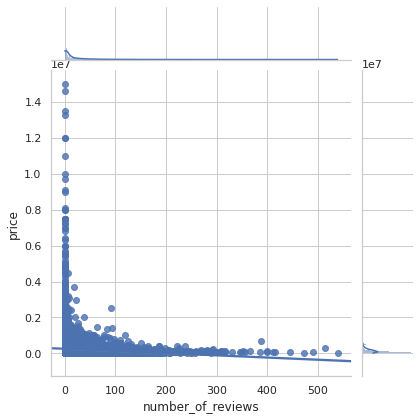

In [ ]:
# setting plotstyle
sns.set(style="whitegrid") 
# price vs. number_of_reviews
sns.jointplot(x='number_of_reviews',y='price', data=listings_df, kind="reg", truncate=False)
plt.show()

(0.0, 22.5)

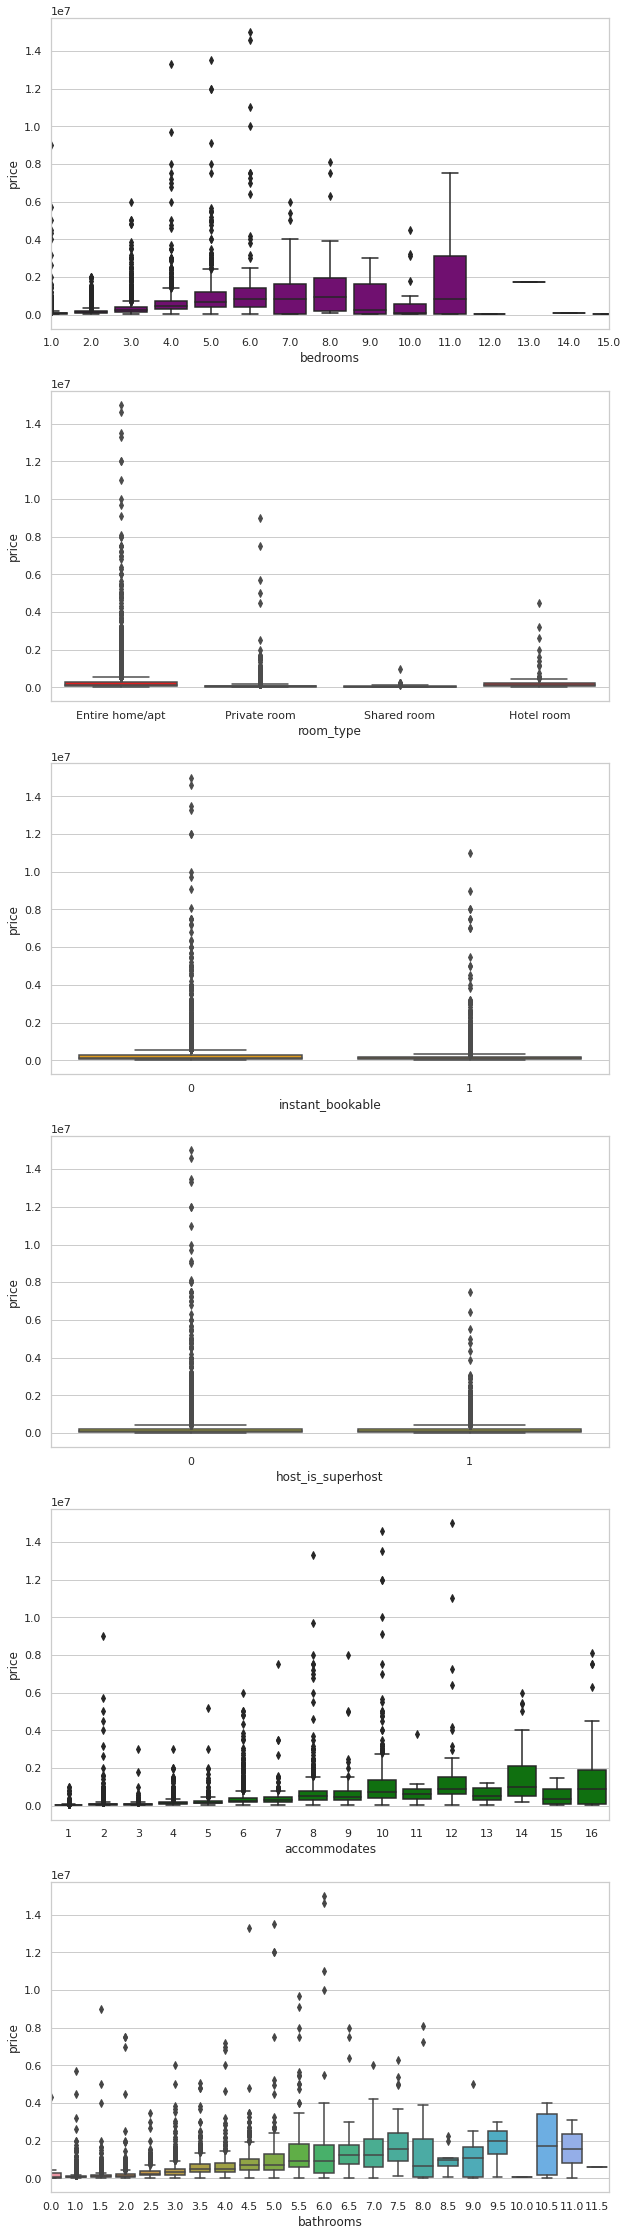

In [ ]:
fig, ax = plt.subplots(6,1,figsize = (10,40))

sns.boxplot(x = 'bedrooms', y = 'price', data = listings_df, ax = ax[0], color = 'purple')
ax[0].set_xlim(0,14)

sns.boxplot(x = 'room_type', y = 'price', data = listings_df, ax = ax[1], color = 'red')

sns.boxplot(y = 'price', x = 'instant_bookable', data = listings_df, ax = ax[2], color='orange')

sns.boxplot(y = 'price', x = 'host_is_superhost', data = listings_df, ax = ax[3],color='yellow')

sns.boxplot(y = 'price', x = 'accommodates', data = listings_df, ax = ax[4],color='green')
sns.boxplot(y = 'price', x = 'bathrooms', data = listings_df, ax = ax[5])
ax[5].set_xlim(0,22.5)


### superhost tags vs other features

In [ ]:
listings_df['host_is_superhost'].value_counts(normalize=True)

0    0.791004
1    0.208996
Name: host_is_superhost, dtype: float64

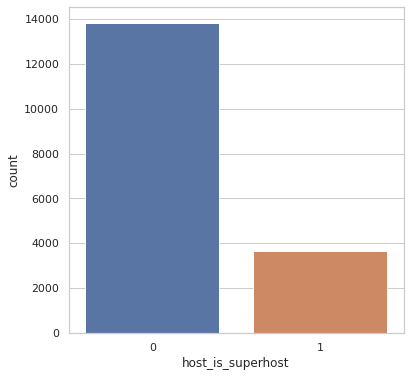

In [ ]:
# 'host_is_superhost' category
# setting plotstyle
sns.set(style="whitegrid") 
fig = plt.figure(figsize = (6,6))
# count plot of superhost
sns.countplot(x=listings_df['host_is_superhost']); 

There is a class imbance in the superhost column.

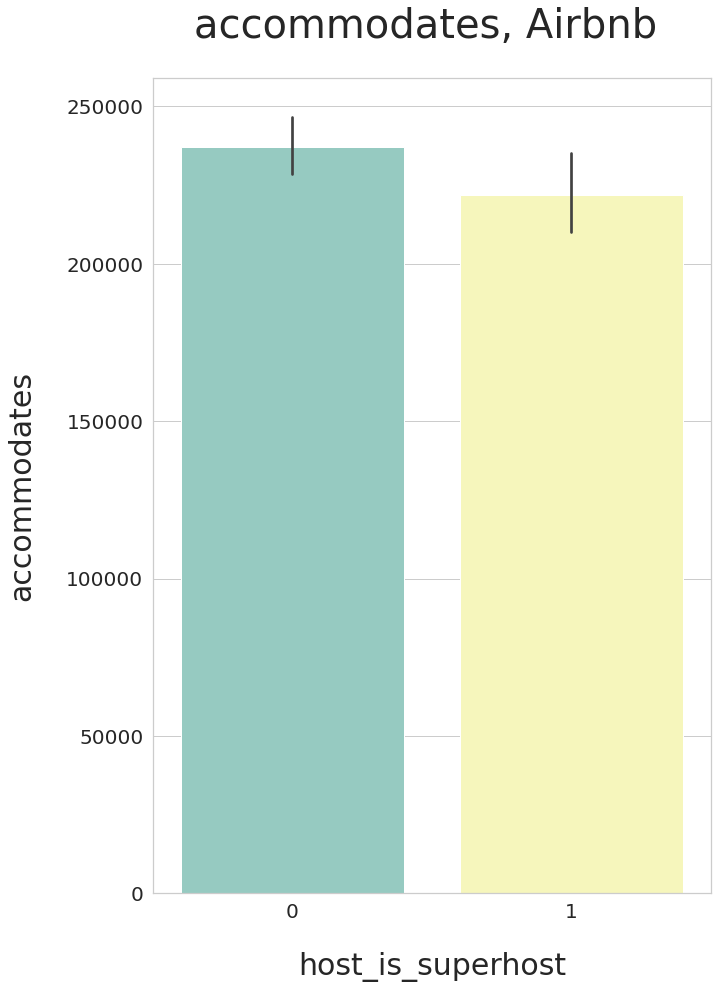

In [ ]:
# Barplot to check the relationship between host is superhost and number of accommodates
fig, ax = plt.subplots()
fig.set_size_inches(10, 15)
ax.axes.set_title("accommodates, Airbnb ",fontsize=40, pad=40)
ax = sns.barplot(x='host_is_superhost', y='price',data=listings_df, palette='Set3')
ax.set_xlabel('host_is_superhost',fontsize=30,labelpad=30)
ax.set_ylabel('accommodates',fontsize=30,labelpad=30)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

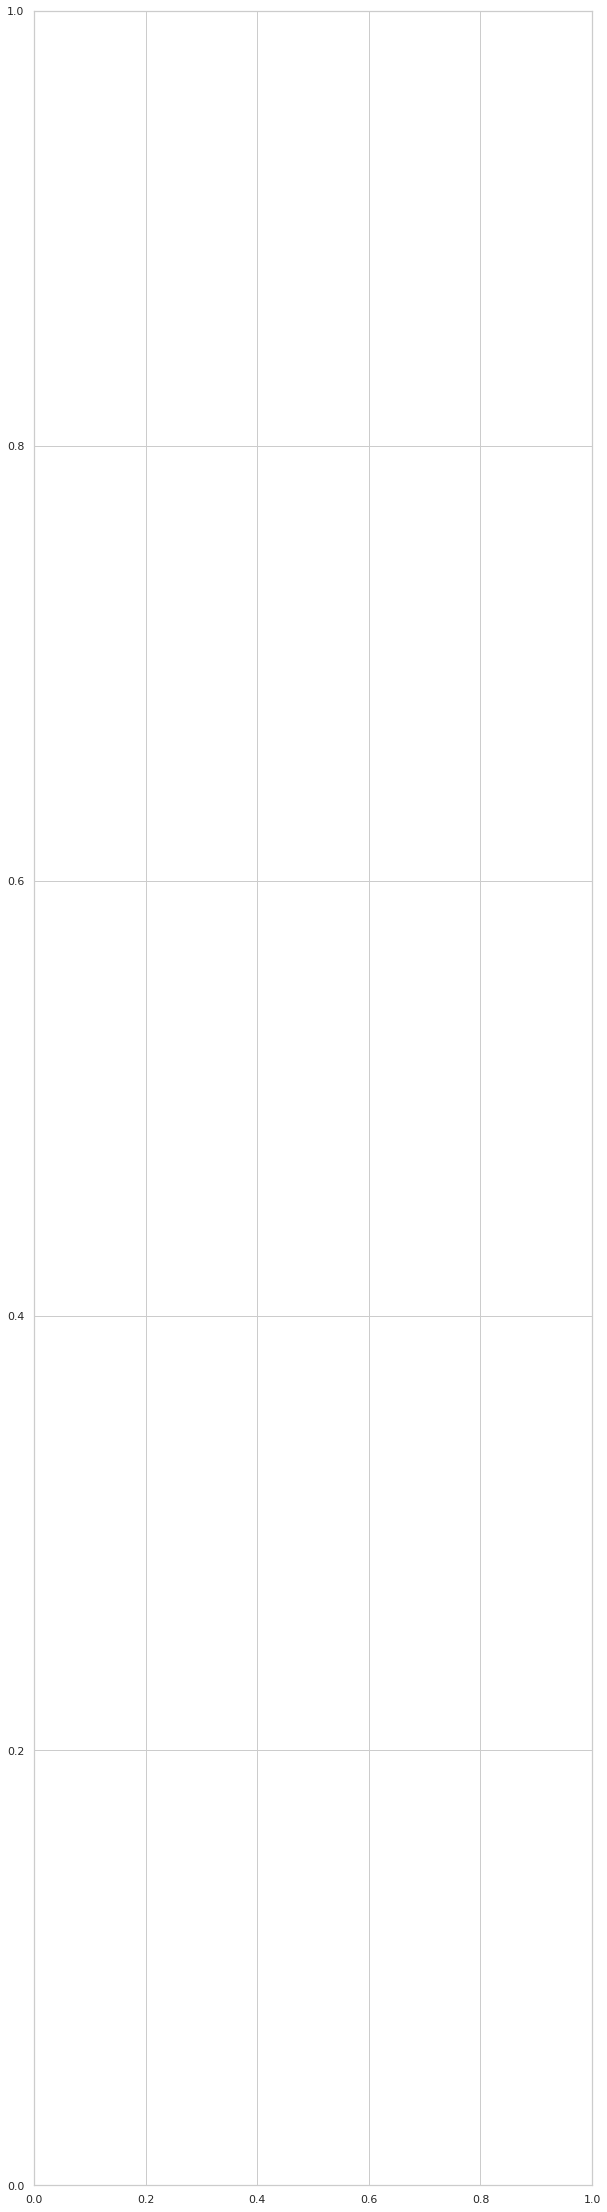

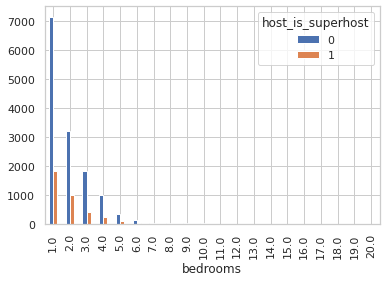

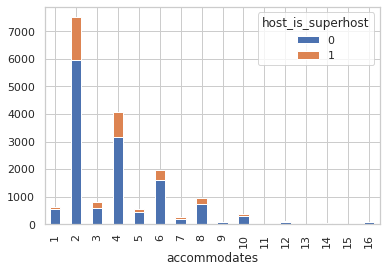

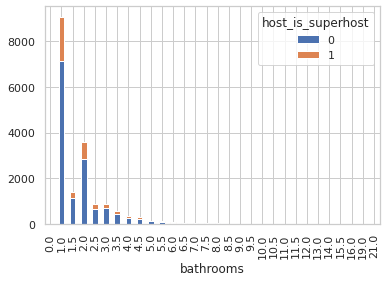

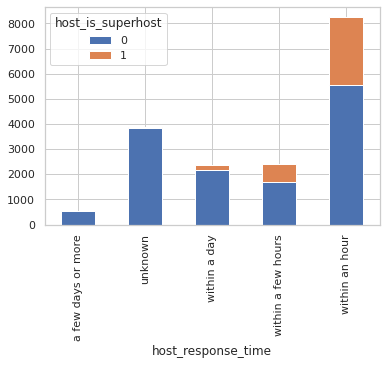

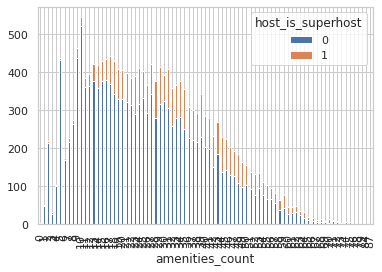

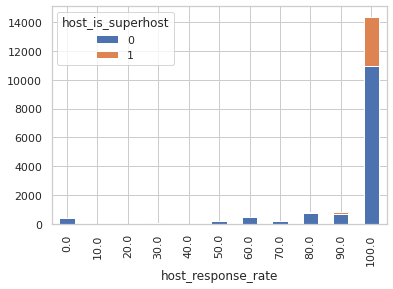

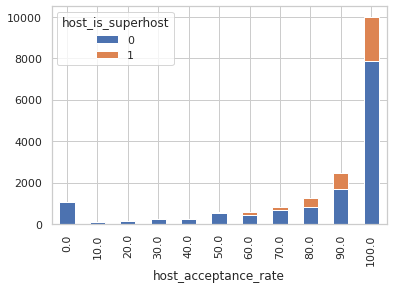

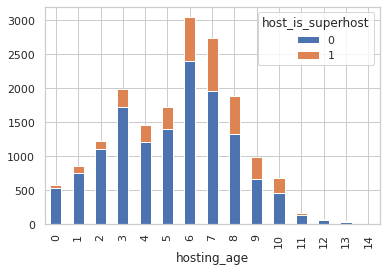

In [ ]:
 fig,ax = plt.subplots(figsize = (10,40))
 pd.crosstab(listings_df['bedrooms'], listings_df['host_is_superhost']).plot(kind='bar')
 pd.crosstab(listings_df['accommodates'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['bathrooms'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['host_response_time'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['amenities_count'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['host_response_rate'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['host_acceptance_rate'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)
 pd.crosstab(listings_df['hosting_age'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True)

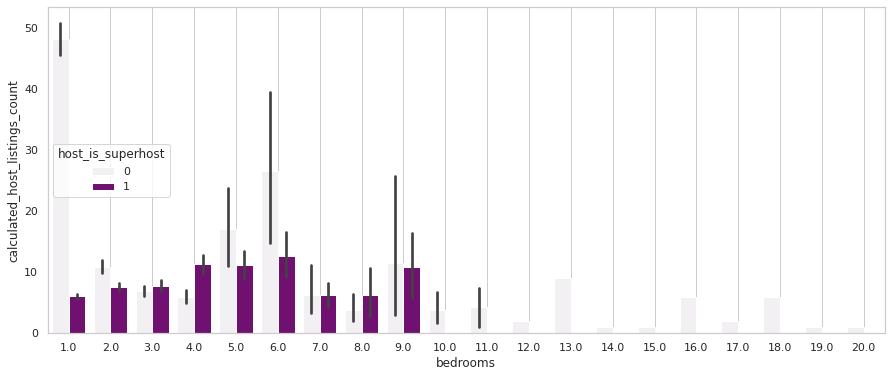

In [ ]:
plt.figure(figsize = (15,6))
sns.barplot(x = 'bedrooms',y = 'calculated_host_listings_count',hue = 'host_is_superhost', data = listings_df, color='purple');
plt.grid()

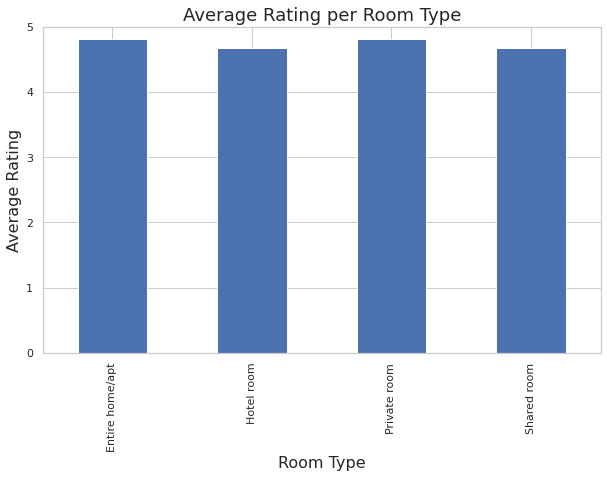

In [ ]:
# Average rating per room type

property_ratings = listings_df.groupby('room_type')['review_scores_rating'].mean()
plt.figure(figsize=(10,6))
property_ratings.plot(kind='bar', ylim = [0,5])
plt.title('Average Rating per Room Type', fontsize=18)
plt.ylabel('Average Rating', fontsize=16)
plt.xlabel('Room Type', fontsize=16);

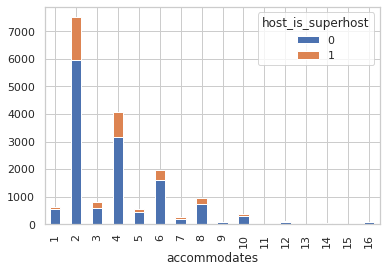

In [ ]:
pd.crosstab(listings_df['accommodates'], listings_df['host_is_superhost']).plot(kind='bar', stacked=True);

### review scores vs other features

**Questions?**

1. What factors, if any influence price?(Regression question)
2. What is the difference between a superhost and a non-superhost? (Classification question)
3. What are the factors unique to listings with above average ratings?

**Questions?**

1. What is the distribution of review scores?
2. what is the relationship between review scores and superhosts?
3. Do reviews influence price?